#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час и построить модель для такого предсказания.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы. Значение метрики RMSE должно быть не больше 48.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-3.2.6"><span class="toc-item-num">3.2.6&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# для разложения временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose
# для проведения теста Дикки-Фуллера на стационарность ряда
from statsmodels.tsa.stattools import adfuller

# для разделения выборок
from sklearn.model_selection import train_test_split
# для масштабирования признаков
from sklearn.preprocessing import StandardScaler
# для подбора параметров GridSearchCV
from sklearn.model_selection import GridSearchCV
# для разделения на фолды в кросс-валидации
from sklearn.model_selection import TimeSeriesSplit
# для кросс-валидации
from sklearn.model_selection import cross_val_score
# для создания pipeline
from sklearn.pipeline import make_pipeline
# для метрики RMSE
from sklearn.metrics import mean_squared_error
# для выявления важности признаков
from sklearn.inspection import permutation_importance

# модель Случайный лес
from sklearn.ensemble import RandomForestRegressor
# модель Дерево решений
from sklearn.tree import DecisionTreeRegressor
# модель Линейная регрессия
from sklearn.linear_model import LinearRegression
# библиотека CatBoost
from catboost import CatBoostRegressor
# библиотека LightGBM
from lightgbm import LGBMRegressor
# для dummy-модели
from sklearn.dummy import DummyRegressor

In [2]:
# загрузим датасет, указав индекс таблицы столбец datetime с датами и заменим тип данных на datetime64
data = pd.read_csv('taxi.csv', parse_dates=['datetime'], index_col=['datetime'])
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датасете 26496 строк, 1 столбец, нет пропусков. Данные в столбце количества заказов целочисленные. Посмотрим подробнее на них.

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


Максимальное значение - 119. А тип данных столбца - int64. Можно смело поменять на int16 (максимальное значение 32767) - в ближайшее время этого типа данных будет достаточно для компании. 

Медианное значение 13, а стандартное отклонение - 9,2, это большое отклонение. Также мы видим слишком большой размах между 75% квартилем и максимальным значением.

In [5]:
data['num_orders'] = data['num_orders'].astype('int16')

Проверим, в хронологическом ли порядке расположены даты и время в индексе - датасет упорядочен. Значит у нас данные с 1 марта по 31 августа 2018 года.

In [6]:
data.index.is_monotonic

True

Данные в датасете разбиты по 10 минут, сделаем ресемплирование по одному часу.

In [7]:
data = data.resample('1H').sum()

In [8]:
# проверим ресемплирование
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


В ходе данного пункта было сделано:
- загрузили данные (с марта по август 2018 года)
- изменили типы данных для даты на datetime64 и для количества заказов с int64 на int16
- установили индексом таблицы столбец с датами
- проверили на наличие пропусков и монотонность
- сделали ресемплирование по 1 часу

## Анализ

Для начала посмотрим на общий график распределения заказов за весь период. В график добавим сглаживание по суткам и неделям. Видим тренд на постепенное увеличение заказов с каждый месяцем.

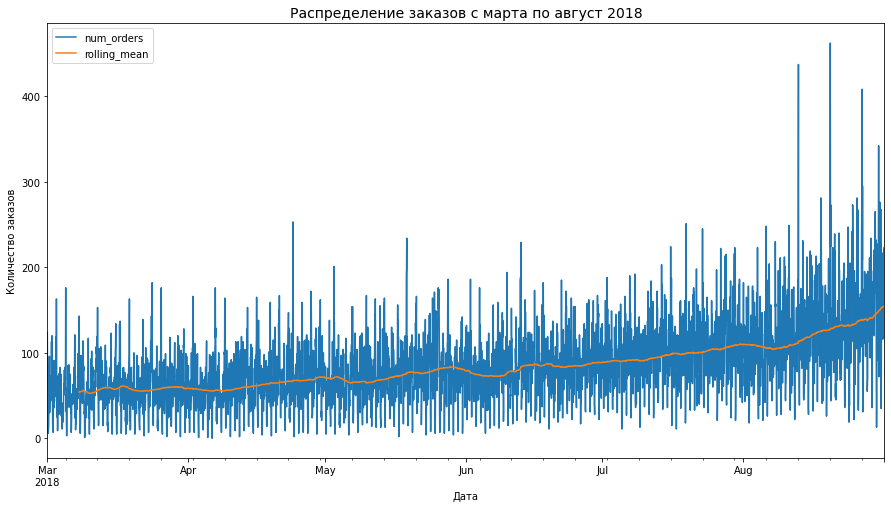

In [9]:
data['rolling_mean'] = data.rolling(24*7).mean() 
data.plot(figsize=(15, 8))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Распределение заказов с марта по август 2018', fontsize=14)
plt.legend();

Разложим временной ряд на три составляющие: тренд, сезонность и шум и построим соответствующие графики.

In [10]:
data = data.drop('rolling_mean', axis=1)
decomposed = seasonal_decompose(data)

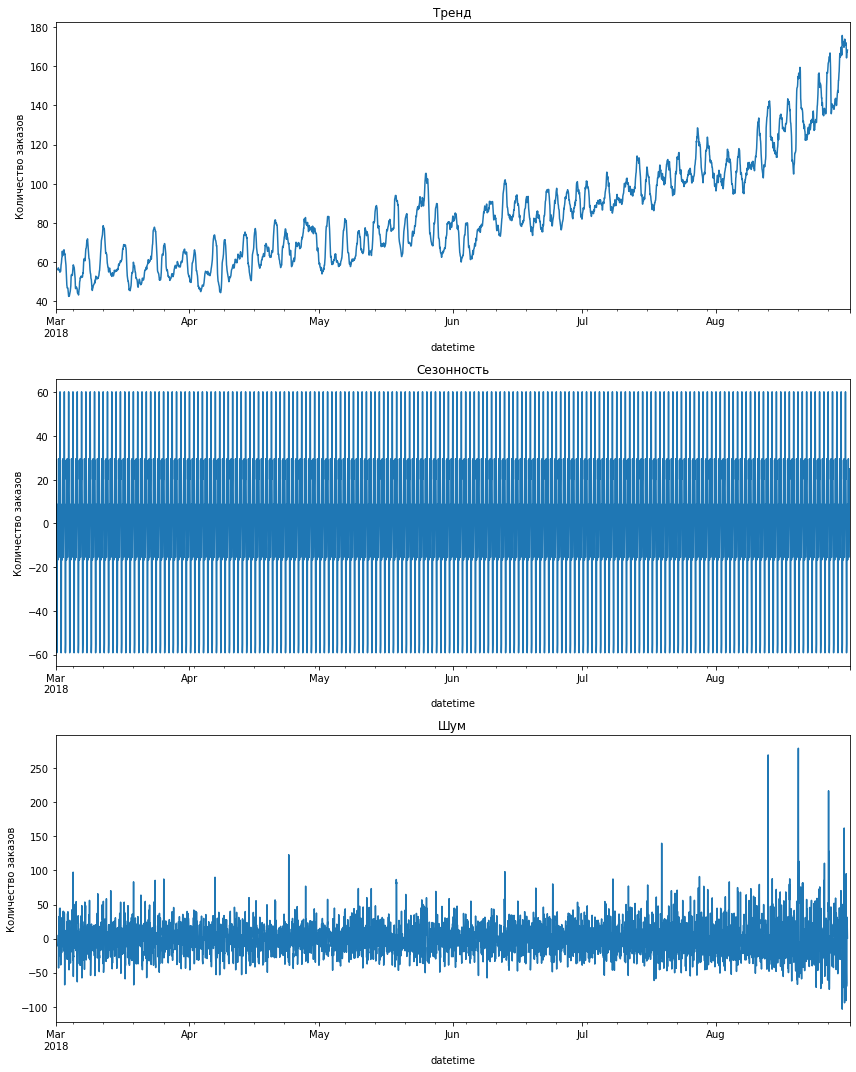

In [11]:
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шум')
plt.ylabel('Количество заказов')
plt.tight_layout();

На графике с трендом хорошо видно увеличение заказов к концу периода примерно в 3 раза. Рассмотрим такие же графики, но на более маленьком периоде: в течение недели (как зависят заказы от дня недели) и в течение пары дней (зависимость от времени суток).

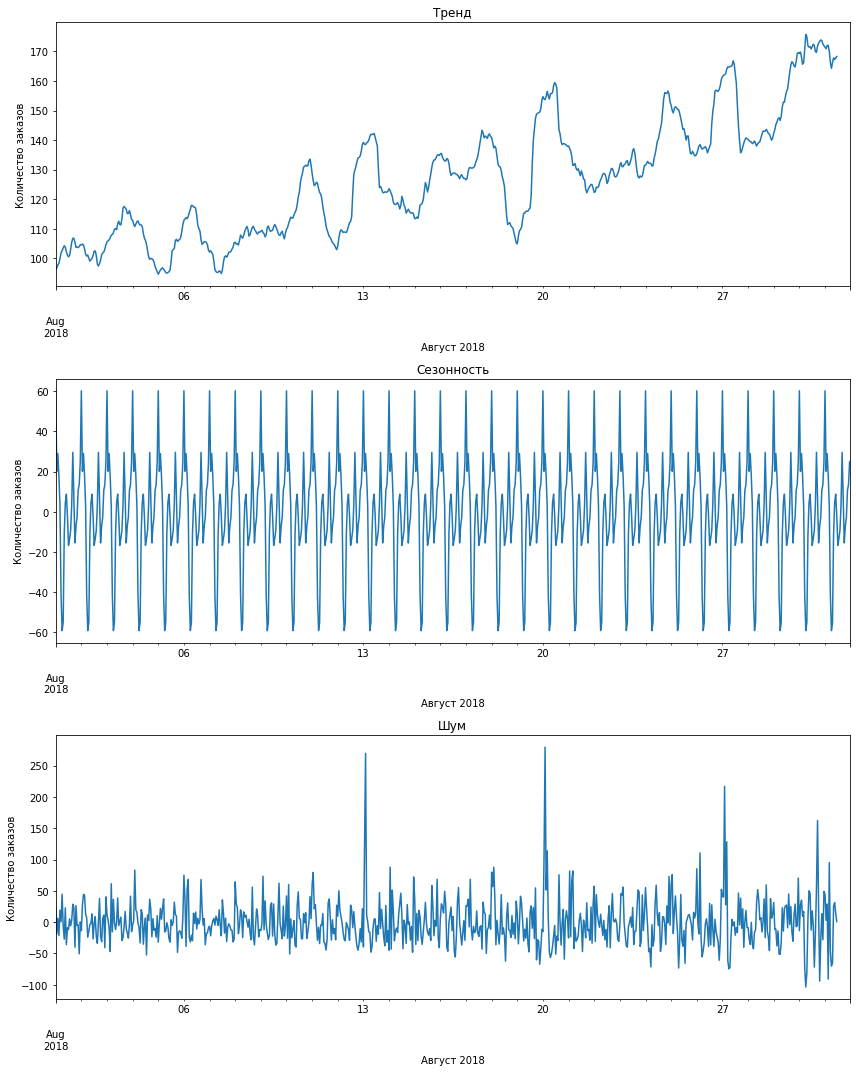

In [12]:
# заказы в августе 2018
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Август 2018')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Август 2018')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('Август 2018')
plt.ylabel('Количество заказов')
plt.tight_layout();

А теперь сделаем ресемплинг по дням и декомпозицию на тренд и сезонность.

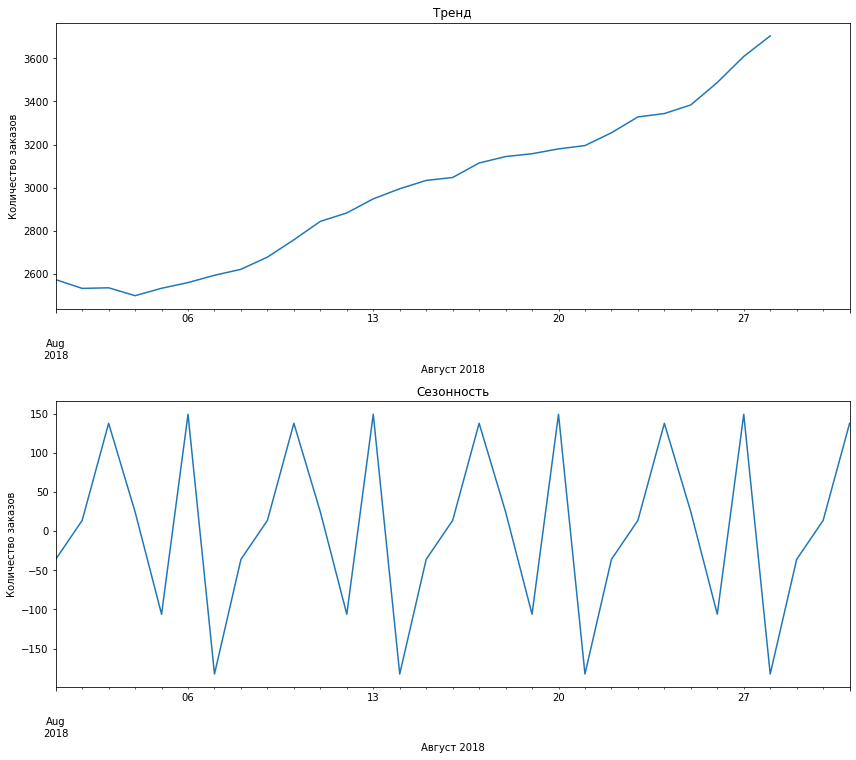

In [13]:
data_day = data.resample('1D').sum()
decomposed_day = seasonal_decompose(data_day)

# заказы в августе 2018
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed_day.trend['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Август 2018')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed_day.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Август 2018')
plt.ylabel('Количество заказов')
plt.tight_layout();

Видим ярко-выраженный спад заказов к выходным. С понедельника опять активный рост заказов.

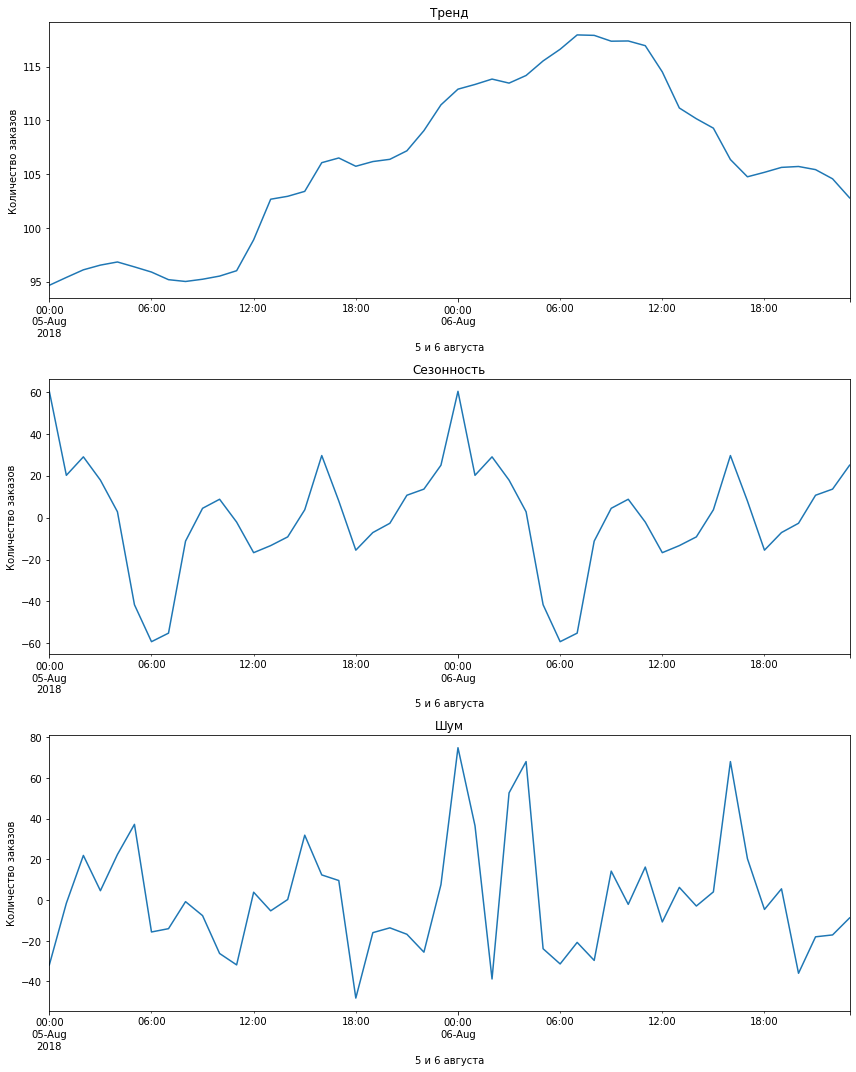

In [14]:
# заказы в 5 (воскресенье) и 6 (понедельник) августа 2018
plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend['2018-08-05':'2018-08-06'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('5 и 6 августа')
plt.ylabel('Количество заказов')
plt.subplot(312)
decomposed.seasonal['2018-08-05':'2018-08-06'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('5 и 6 августа')
plt.ylabel('Количество заказов')
plt.subplot(313)
decomposed.resid['2018-08-05':'2018-08-06'].plot(ax=plt.gca())
plt.title('Шум')
plt.xlabel('5 и 6 августа')
plt.ylabel('Количество заказов')
plt.tight_layout();

Пики заказов в полночь, к 6 утра виден максимальный спад заказов, независимо от дня недели.

Проверим стационарность нашего временного ряда. Если временной ряд является стационарным, его легче моделировать, если ряд нестационарный, его надо сделать таким.

Найдём скользящие стандартное отклонение и среднее по скользящему окну и выведем их на графике.

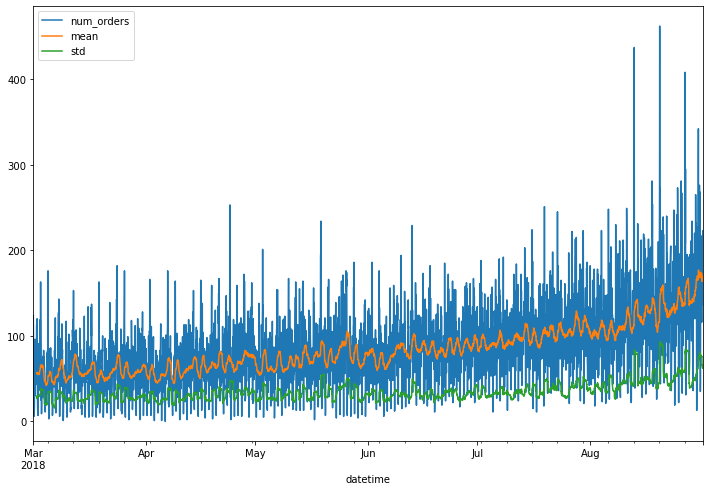

In [15]:
data['mean'] = data['num_orders'].rolling(24).mean()
data['std'] = data['num_orders'].rolling(24).std()
data.plot(figsize=(12, 8));

И среднее, и отклонение постепенно увеличиваются. По графику можно сказать, что временной ряд нестационарный. Проверим его с помощью статистического теста Дики-Фуллера.

Тест Дики-Фуллера можно использовать для определения наличия единичного корня в ряду (единичный корень указывает на то, что статистические свойства данного ряда непостоянны во времени) и узнать, является ли ряд стационарным. Нулевой и альтернативной гипотезой этого теста являются:

<b>Нулевая гипотез</b>а: временной ряд имеет единичные корни, значит ряд не стационарен.

<b>Альтернативная гипотеза</b>: временной ряд не имеет единичных корней, значит ряд стационарен.

Тест на стационарность: если значение p-value меньше критического значения выбранного доверительного интервала, мы можем отвергнуть нулевую гипотезу (то есть ряд является стационарным). Когда p-value больше критического значения, мы не можем отклонить нулевую гипотезу (что означает, что ряд не является стационарным).

In [16]:
test_df = adfuller(data['num_orders'], regression='ctt')
print('p-value:', test_df[1])
if test_df[1] > 0.05:
    print('Есть единичные корни, ряд нестационарен.')
else:
    print('Единичных корней нет, ряд стационарен.')

p-value: 4.05493978330971e-17
Единичных корней нет, ряд стационарен.


Тест показывает, что наш ряд стационарен. Но тест мог не углядеть нестационарность из-за малого количества наблюдений и/или нечуткого указания других параметров adfuller. Чтобы ряд сделать визуально более стационарным, найдём разности его значений. Для поиска разностей временного ряда применим метод shift(). Все значения он сдвигает вдоль временной оси на один шаг вперёд.

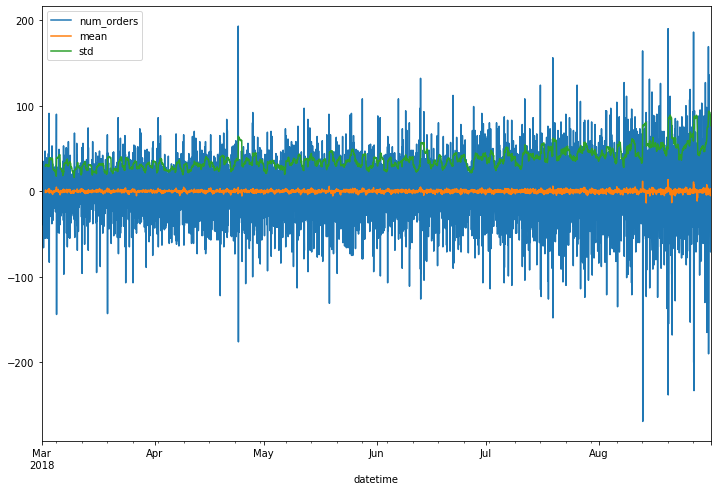

In [17]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift.plot(figsize=(12, 8));

В ходе этого пункта проанализировали графики и выяснили:
- количество заказов с каждым месяцем постепенно увеличивается
- в течение недели происходит спад к выходным, в понедельник снова начинается рост заказов
- в течение суток происходит спад к 6 утра, самое пиковое время для заказов - около полуночи
- наш временной ряд визуально нестационарный, хотя тест Дики-Фуллера показывает обратное
- при сдвиге на один шаг с помощью скользящего окна размером 24 временной ряд заметно сглаживается

## Обучение

### Подготовка признаков

Создадим признаки для горизонта прогнозирования в один шаг. Скользящее окно выберем размером 24 - сутки в нашем датасете. Количество отстающих значений (лагов) - 18. Это как раз покроет время от минимальной загрузки в 6 утра до максимального пика в полночь.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 18, 24)
data.head(10)

,num_orders,mean,std,year,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,2018,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2018,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,2018,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,2018,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,NaN,2018,3,5,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,NaN,2018,3,6,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,NaN,2018,3,7,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,NaN,NaN,2018,3,8,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# удалим пропуски после добавления признаков
data.dropna(inplace=True)

Разделим данные на 2 выборки: обучающую и тестовую в соотношении 90%:10%. Валидационную выборку создавать не будем, так как обучать модели и подбирать гиперпараметры будем кросс-валидацией.

Затем создадим переменные для обучения моделей.

In [20]:
# без перемешивания данных в выборках
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [21]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
 
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [22]:
# проверим размеры
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(3952, 24)
(3952,)
(440, 24)
(440,)


In [23]:
# проверим корректность деления, чтобы данные из тестовой выборки не попали в трейн
print(target_train.index.min(), target_train.index.max())
print(target_test.index.min(), target_test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### Обучение моделей

#### Дерево решений

In [24]:
# Дерево решений с максимальной глубиной 20
param_grid = {'max_depth': range(1, 21)}
tscv = TimeSeriesSplit(n_splits=5)

model = DecisionTreeRegressor(random_state=2501)

grid_search = GridSearchCV(model, param_grid, cv=tscv, \
                           scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train)
rmse_tree = -grid_search.best_score_

print(f'RMSE Дерева решений: {rmse_tree}') 
print(f'Лучшие гиперпараметры: {grid_search.best_params_}')

RMSE Дерева решений: 29.857355855451527
Лучшие гиперпараметры: {'max_depth': 7}


#### Случайный лес

In [25]:
# Случайный лес
param_grid = {'max_depth': range(1, 10), 
             'n_estimators': range(1, 62, 10)}
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(random_state=2501)
grid_search = GridSearchCV(model, param_grid, cv=tscv, \
                           scoring='neg_root_mean_squared_error', n_jobs=1)
grid_search.fit(features_train, target_train)
rmse_forest = -grid_search.best_score_

print(f'RMSE Случайного леса: {rmse_forest}') 
print(f'Лучшие гиперпараметры: {grid_search.best_params_}')

RMSE Случайного леса: 25.285446484412006
Лучшие гиперпараметры: {'max_depth': 9, 'n_estimators': 51}


RMSE деревянных моделей на обучающей выборке очень хорошее, нужно будет позже проверить их на тестовой модели. Для заказчика важен RMSE не выше 48.

#### Линейная регрессия

In [26]:
# без масштабирования признаков
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)

rmse_linreg = -cross_val_score(model, features_train, target_train, cv=tscv, \
                        scoring='neg_root_mean_squared_error').mean()
model.fit(features_train, target_train)
print(f'RMSE Линейной регрессии: {rmse_linreg}')

RMSE Линейной регрессии: 23.546498400632988


In [27]:
# с масштабированием признаков
pipeline = make_pipeline(StandardScaler(), LinearRegression())
tscv = TimeSeriesSplit(n_splits=5)

rmse_linreg_scaler = -cross_val_score(pipeline, features_train, target_train, cv=tscv, \
                        scoring='neg_root_mean_squared_error').mean()
pipeline.fit(features_train, target_train)
print(f'RMSE Линейной регрессии с масштабом: {rmse_linreg_scaler}')

RMSE Линейной регрессии с масштабом: 23.546498400633006


Масштабирование признаков не влияет на RMSE Линейной регрессии, метрика еще ниже, чем у деревянных моделей.

#### CatBoost

In [28]:
param_grid = [{
    'learning_rate': [0.03, 0.1],
    'depth': [1, 10],
    'l2_leaf_reg': [3, 5, 7, 9],
    'has_time': [True],
    'random_state': [2501],
}]
tscv = TimeSeriesSplit(n_splits=5)

model = CatBoostRegressor(iterations=50, loss_function='RMSE', verbose=0)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error', \
                           n_jobs=1)
grid_search.fit(features_train, target_train)
rmse_catboost = -grid_search.best_score_

print(f'RMSE CatBoost: {rmse_catboost}') 
print(f'Лучшие гиперпараметры: {grid_search.best_params_}')

RMSE CatBoost: 26.453200709641152
Лучшие гиперпараметры: {'depth': 10, 'has_time': True, 'l2_leaf_reg': 3, 'learning_rate': 0.1, 'random_state': 2501}


CatBoost показала значение метрики RMSE хуже, чем Линейная регрессия и Случайный лес, но в рамках допустимого. Нужно будет проверить ее на тестовой выборке.

#### LightGBM

In [29]:
param_grid = [{
    'max_depth': [5, 10, 15, 20],
    'num_leaves':[31, 100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.15],
    'random_state': [2501]
}]
tscv = TimeSeriesSplit(n_splits=5)

model = LGBMRegressor(n_jobs=1)
grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
grid_search.fit(features_train, target_train)
rmse_lgbm = -grid_search.best_score_

print(f'RMSE LGBM: {rmse_lgbm}') 
print(f'Лучшие гиперпараметры: {grid_search.best_params_}')

RMSE LGBM: 23.12253033180776
Лучшие гиперпараметры: {'learning_rate': 0.15, 'max_depth': 10, 'num_leaves': 31, 'random_state': 2501}


У LGBM также хорошее значение метрики RMSE. Соберем все данные по обучению моделей в одну таблицу для наглядности.

#### Анализ моделей

In [30]:
total = pd.DataFrame(columns=['RMSE'],
                    index=['Дерево решений', 'Случайный лес', 'Линейная регрессия', 'CatBoost', \
                           'LightGBM'],
                    data=[rmse_tree, rmse_forest, rmse_linreg, rmse_catboost, rmse_lgbm])
total

,RMSE
Дерево решений,29.857356
Случайный лес,25.285446
Линейная регрессия,23.546498
CatBoost,26.453201
LightGBM,23.122530


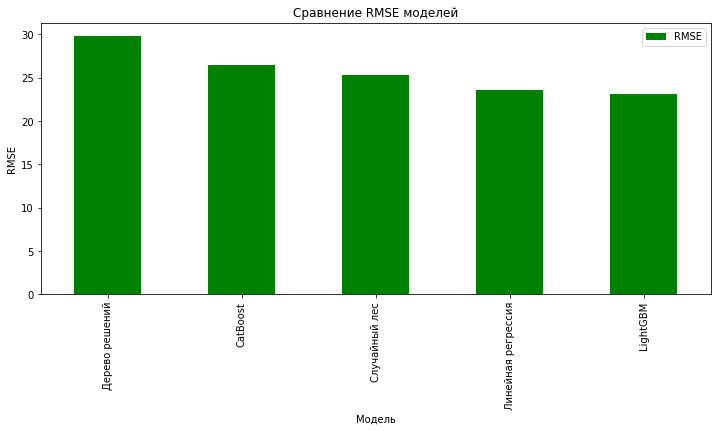

In [31]:
total.sort_values(by='RMSE', ascending=False).plot.bar(y='RMSE', figsize=(12,5), color='green')
plt.title('Сравнение RMSE моделей')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.show()

Самый лучший показатель RMSE у модели LGBM, чуть больше у Линейной регрессии, самый худший - у Дерева решений. Но все значения RMSE подходят для дальнейшей проверки на тестовых данных.

## Тестирование

Проверим все модели с лучшими гиперпараметрами на тестовой выборке.

In [32]:
# Дерево решений с максимальной глубиной 7
model = DecisionTreeRegressor(max_depth=7, random_state=2501)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_tree = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE Дерева решений: {rmse_tree}')

RMSE Дерева решений: 50.50609112573597


In [33]:
# Случайный лес
model = RandomForestRegressor(max_depth=9, n_estimators=51, random_state=2501)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_forest = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE Случайного леса: {rmse_forest}')

RMSE Случайного леса: 42.701669504864704


In [34]:
# Линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_linreg = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE Линейной регрессии: {rmse_linreg}')

RMSE Линейной регрессии: 37.47234041687298


In [35]:
# CatBoost
model = CatBoostRegressor(depth=10, has_time=True, l2_leaf_reg=3, learning_rate=0.1, \
                          random_state=2501, loss_function='RMSE', verbose=0)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_catboost = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE CatBoost: {rmse_catboost}')

RMSE CatBoost: 44.464975369994754


In [36]:
# LightGBM
model = LGBMRegressor(learning_rate=0.15, max_depth=10, num_leaves=31, random_state=2501, \
                      n_jobs=1)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_lgbm = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE LGBM: {rmse_lgbm}')

RMSE LGBM: 40.796038071842055


Соберем всю полученную информацию в одну таблицу и выведем на графике.

In [37]:
final = pd.DataFrame(columns=['RMSE'],
                    index=['Дерево решений', 'Случайный лес', 'Линейная регрессия', 'CatBoost', \
                           'LightGBM'],
                    data=[rmse_tree, rmse_forest, rmse_linreg, rmse_catboost, rmse_lgbm])
final

,RMSE
Дерево решений,50.506091
Случайный лес,42.701670
Линейная регрессия,37.472340
CatBoost,44.464975
LightGBM,40.796038


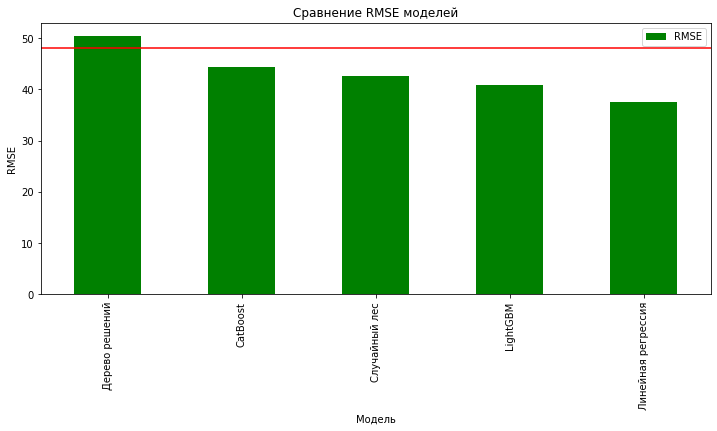

In [38]:
final.sort_values(by='RMSE', ascending=False).plot.bar(y='RMSE', figsize=(12,5), color='green')
plt.title('Сравнение RMSE моделей')
plt.xlabel('Модель')
plt.ylabel('RMSE')
plt.axhline(y=48, color='r')
plt.show()

Четыре модели из пяти (кроме Дерева решений) на тестовой выборке смогли показать результат RMSE меньше 48. Лучше всех предсказала количество заказов такси модель Линейная регрессия - 37.47.

Проверим модель на адекватность.

In [39]:
model = DummyRegressor(strategy="median")
model.fit(features_train, target_train)
predicted_valid = model.predict(features_test)
rmse_dummy = mean_squared_error(target_test, predicted_valid, squared=False)

print(f'RMSE Dummy-модели: {rmse_dummy}')

RMSE Dummy-модели: 87.21093811714634


Наши четыре модели действительно оказались рабочими, так как качество RMSE у них намного лучше, чем у DummyRegressor. Модели прошли проверку на адекватность.

## Вывод

В ходе данного проекта было сделано:
1. Подготовлены данные для анализа временных рядов:
- изменили типы данных для даты на datetime64 и для количества заказов с int64 на int16
- установили индексом таблицы столбец с датами
- проверили на наличие пропусков и монотонность
- сделали ресемплирование по 1 часу
2. С помощью графиков выяснили:
- количество заказов с каждым месяцем постепенно увеличивается
- в течение недели происходит спад к выходным, в понедельник снова начинается рост заказов
- в течение суток происходит спад к 6 утра, самое пиковое время для заказов - около полуночи
3. Подготовили признаки для обучения моделей.
4. Обучили пять разных моделей на тренировочной выборке. У всех моделей RMSE получилось ниже 48.
5. Проверили все модели на тестовой выборке - четыре модели прошли проверку. Лучшей моделью оказалась Линейная регрессия с RMSE 37.47.
6. Проверили модель на адекватность.